### First experimentation with Neural ODEs

I want this notebook to model some physical systems using neural ODEs. If we like what we see, we can move on to more complex systems or to a liquid NN.

In [6]:
import tensorflow as tf
print(tf.__version__)
from tfdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  0


In [2]:
#define truth ODE

def damped_harmonic_oscillator(t, u, args):
    """
    simple example to get started.
    t: time
    u: state of [x', x'']
    args: parameters describing system [m,k,c]: m is the mass, k is spring constant, c is damping
    """ 
    [m,k,c] = args[0], args[1], args[2]
    x, v = u[0], u[1]
    dx_dt = v
    dv_dt = -c * v / m - k * x / m
    return tf.stack([dx_dt, dv_dt])

def parameterized_ODE(t, u, args):
    """
    the model ODE we will use to fit to see if we recover the right ODE
    t: time
    u: state of [x', x''...]
    args: 6 parameters describing system x'=a1+b1*x+c1*y, y'=a2+b2*x+c2*y
    """ 
    [a1,b1,c1,a2,b2,c2] = args
    x, y = u[0], u[1]
    dx_dt = a1+b1*x+c1*y
    dy_dt = a2+b2*x+c2*y
    return tf.stack([dx_dt, dy_dt])

#create training data from analytical solution
true_m=1
true_k=20
true_c=2
true_physical_params = [true_m,true_k,true_c]
true_params=[0,0,1,0,-true_k/true_m,-true_c/true_m]
t_begin=0.
t_end=2.
t_nsamples=int(100*(t_end-t_begin)) #100 samples per second
t_space = np.linspace(t_begin, t_end, t_nsamples)

def analytical_solution(t,init_amp=1,init_phase=np.pi/2):
    m,k,c=true_physical_params
    damping_ratio=c/(2*np.sqrt(m*k))
    frequency=np.sqrt(k/m)
    x=init_amp*np.exp(-damping_ratio*frequency*t)*np.sin(np.sqrt(1-damping_ratio**2)*frequency*t+init_phase)
    v=x*(-damping_ratio*frequency)+ \
        init_amp*np.exp(-damping_ratio*frequency*t) * \
        np.cos(np.sqrt(1-damping_ratio**2)*frequency*t+init_phase)*np.sqrt(1-damping_ratio**2)*frequency
    return x,v

x_an,v_an=analytical_solution(t_space)
dataset_outs = [tf.expand_dims(x_an, axis=1), \
                tf.expand_dims(v_an, axis=1)] #list of 2 tensors of shape (t_nsamples,1)


In [3]:
#build neural ODE model
start_from_trained_state=True
rerun_and_overwrite=False #you could do this from scratch, but I already trained for 1600 epochs so I'll just load my result

#get the initial conditions
t_space_tensor = tf.constant(t_space)
initial_x=x_an[0]; initial_v=v_an[0]
x_init = tf.constant([initial_x], dtype=t_space_tensor.dtype)
v_init = tf.constant([initial_v], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([x_init, v_init], dtype=t_space_tensor.dtype)
if start_from_trained_state:
    with open('damped_harmonic_history.pkl', 'rb') as f:
        history = pickle.load(f)
    print('starting from state:',history['params'][-1])
    args=[tf.Variable(history['params'][-1][i], name='p' + str(i+1),trainable=True,
              dtype=t_space_tensor.dtype) for i in range(0,6)]
else:
    args = [tf.Variable(initial_value=0., name='p' + str(i+1), trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0, 6)]
    history={'epoch':[],'loss':[],'params':[]}

learning_rate = 0.05
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) #legacy runs better on M1 processors

def net(ODE=parameterized_ODE):
    return odeint(lambda ts, u0: ODE(ts, u0, args),
                  u_init, t_space_tensor)
def loss_func(num_sol):
    #sum of squares of x and v
    return tf.reduce_sum(tf.square(dataset_outs[0] - num_sol[:, 0])) + \
         tf.reduce_sum(tf.square(dataset_outs[1] - num_sol[:, 1]))
#train
if rerun_and_overwrite:
    for epoch in range(history['epoch'][-1]+1,history['epoch'][-1]+1+1000):
        with tf.GradientTape() as tape:
            num_sol = net()
            loss_value = loss_func(num_sol)
        history['epoch'].append(epoch)
        history['loss'].append(loss_value.numpy())
        history['params']=np.concatenate((history['params'],np.array([args])),axis=0)
        if epoch%10==0:
            print("Epoch:", epoch, " loss:", loss_value.numpy())
        grads = tape.gradient(loss_value, args)
        optimizer.apply_gradients(zip(grads, args))
    history['params']=np.array(history['params'])

    with open('damped_harmonic_history.pkl', 'wb') as f:
        pickle.dump(history, f)
#is it possible to build this to include t, so I can train it from a couple examples with different initial conditions?

starting from state: [ 5.96053271e-10  2.76513013e-07  1.00000003e+00 -9.40972576e-08
 -2.00000016e+01 -1.99999999e+00]


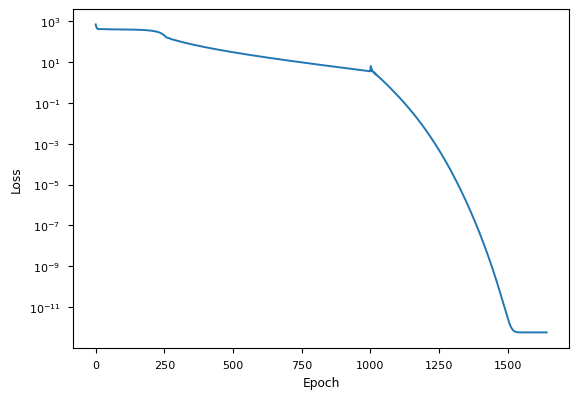

In [4]:
plt.semilogy(history['epoch'],history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Truth parameters: [0, 0, 1, 0, -20.0, -2.0]
Learned parameters: [5.960532707830402e-10, 2.76513013326886e-07, 1.000000034911227, -9.409725762122059e-08, -20.00000163706571, -1.999999988471362]


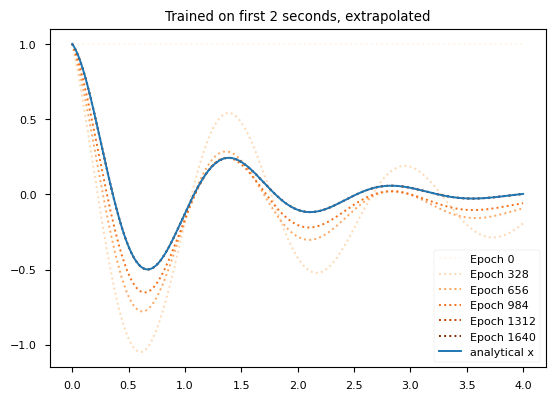

(400, 2, 1)


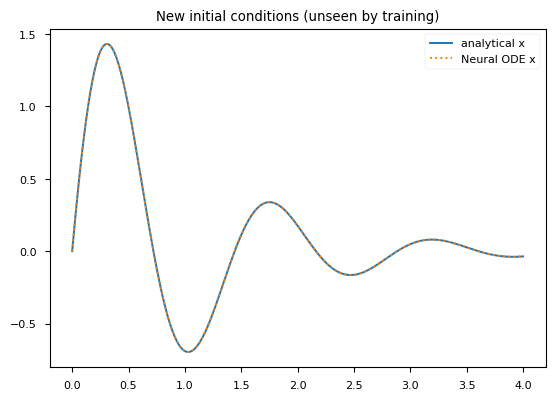

In [7]:
#compare results
print('Truth parameters:', true_params)
with open('damped_harmonic_history.pkl', 'rb') as f:
        history = pickle.load(f)
args=[tf.Variable(history['params'][-1][i], name='p' + str(i+1),trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0,6)]
print("Learned parameters:", [args[i].numpy() for i in range(0, 6)])

#test solution, but extrapolated beyone what was trained
t_begin=0.
t_end=4.
t_nsamples=int(100*(t_end-t_begin)) #100 samples per second
t_space = np.linspace(t_begin, t_end, t_nsamples)
t_space_tensor = tf.constant(t_space)
x_an,v_an=analytical_solution(t_space)
initial_x=x_an[0]; initial_v=v_an[0]
x_init = tf.constant([initial_x], dtype=t_space_tensor.dtype)
v_init = tf.constant([initial_v], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([x_init, v_init], dtype=t_space_tensor.dtype)


n_plot_epochs=5
n_epochs=len(history['epoch'])
color_sv=np.linspace(0,1,n_plot_epochs+1)
norm=plt.Normalize(vmin=0, vmax=1)
n_jump=n_epochs//5
for epoch_i,color_value in enumerate(color_sv):
    color=cm.Oranges.__call__(color_value)
    args=[tf.Variable(history['params'][epoch_i*n_jump][i], name='p' + str(i+1),trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0,6)]
    num_sol = net()
    x_num_sol = num_sol[:, 0].numpy()
    y_num_sol = num_sol[:, 1].numpy()
    plt.plot(t_space,x_num_sol,label='Epoch {}'.format(epoch_i*n_jump),color=color,linestyle=':')

plt.title('Trained on first 2 seconds, extrapolated')
plt.plot(t_space,x_an,label='analytical x')
plt.legend()
plt.show()

print(np.shape(num_sol))

#test with new initial conditions:
x_an_new,v_an_new=analytical_solution(t_space,2,0)
initial_x_new=x_an_new[0]; initial_v_new=v_an_new[0]
x_init = tf.constant([initial_x_new], dtype=t_space_tensor.dtype)
v_init = tf.constant([initial_v_new], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([x_init, v_init], dtype=t_space_tensor.dtype)
num_sol2=odeint(lambda ts, u0: parameterized_ODE(ts, u0, args),
                  u_init, t_space_tensor)
x_num_sol = num_sol2[:, 0].numpy()
y_num_sol = num_sol2[:, 1].numpy()
plt.title('New initial conditions (unseen by training)')
plt.plot(t_space,x_an_new,label='analytical x')
plt.plot(t_space,x_num_sol,label='Neural ODE x',linestyle=':')
plt.legend()
plt.show()





### Let's try something crazy
How will this perform on a much more complex system? Google's stock price

/var/folders/lq/sf1n2rf17x54_sh6w6b_fwm40000gn/T/ipykernel_10421/417301392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_close['Change']=google_close['Close']-google_close['Close'].shift()
/var/folders/lq/sf1n2rf17x54_sh6w6b_fwm40000gn/T/ipykernel_10421/417301392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_close['Change'][0]=google_close['Change'][1]
/var/folders/lq/sf1n2rf17x54_sh6w6b_fwm40000gn/T/ipykernel_10421/417301392.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

<Axes: xlabel='Date'>

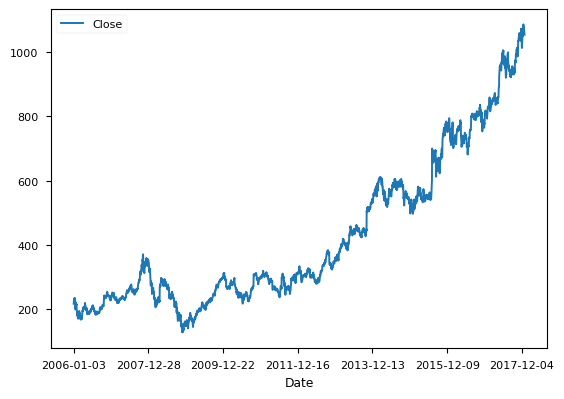

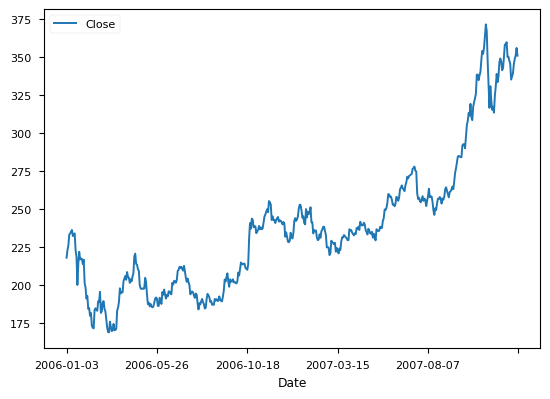

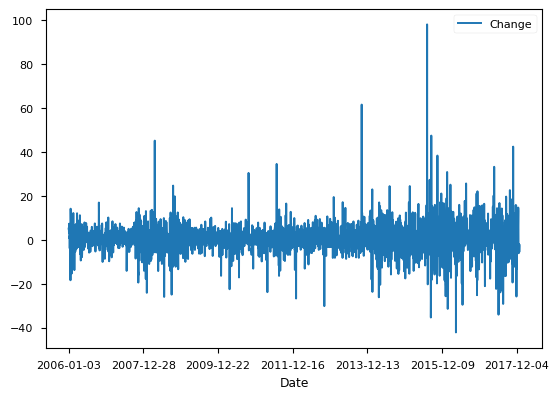

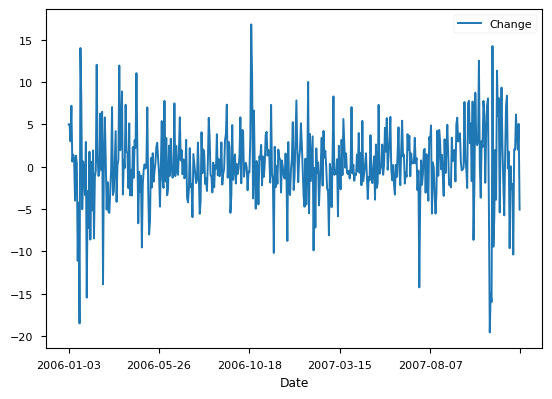

In [42]:
import pandas as pd
google_stock=pd.read_csv('/Users/matt/ML_experimentation/data/DJIA_30_Stocks/GOOGL_2006-01-01_to_2018-01-01.csv')
google_close=google_stock[['Date','Close']]
google_close['Change']=google_close['Close']-google_close['Close'].shift()
google_close['Change'][0]=google_close['Change'][1]

from datetime import datetime
starttime = datetime.strptime(google_close['Date'][0], '%Y-%m-%d')
days_since=[]
for datestring in google_close['Date']:
    datetime = datetime.strptime(datestring, '%Y-%m-%d')
    time_since=(datetime-starttime).days
    days_since.append(float(time_since))
google_close['time_since'] = days_since
google_close

subset=google_close[:500]
google_close.plot('Date','Close')
subset.plot('Date','Close')

google_close.plot('Date','Change')
subset.plot('Date','Change')


Epoch: 0  loss: 1225164.7589


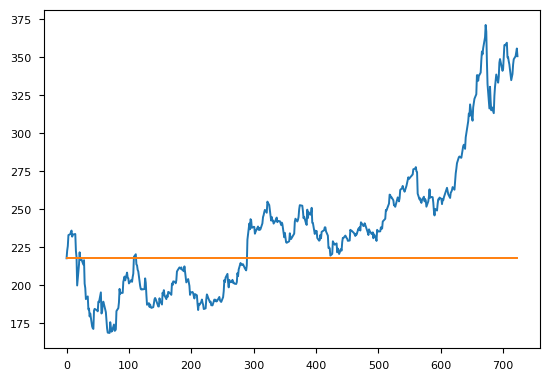

Epoch: 1  loss: 1.7115907365349115e+37
Epoch: 2  loss: 10902785.382564472
Epoch: 3  loss: 3832378.9906823635
Epoch: 4  loss: 6952336.963470518
Epoch: 5  loss: 8585440.603804931
Epoch: 6  loss: 9567848.129104141
Epoch: 7  loss: 10221781.233784132
Epoch: 8  loss: 10687807.773343295
Epoch: 9  loss: 11036280.727758864


In [39]:
t_space=subset['time_since']

#build neural ODE model
start_from_trained_state=False
rerun_and_overwrite=True #you could do this from scratch, but I already trained for 1600 epochs so I'll just load my result

#get the initial conditions
t_space_tensor = tf.constant(t_space)
initial_x=subset['Close'][0]; initial_v=subset['Change'][0]
x_init = tf.constant(initial_x, dtype=t_space_tensor.dtype)
v_init = tf.constant(initial_v, dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([x_init, v_init], dtype=t_space_tensor.dtype)
if start_from_trained_state:
    with open('ODE_stocks_history.pkl', 'rb') as f:
        history = pickle.load(f)
    print('starting from state:',history['params'][-1])
    args=[tf.Variable(history['params'][-1][i], name='p' + str(i+1),trainable=True,
              dtype=t_space_tensor.dtype) for i in range(0,6)]
else:
    args = [tf.Variable(initial_value=0., name='p' + str(i+1), trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0, 6)]
    history={'epoch':[],'loss':[],'params':[]}

learning_rate = 0.05
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) #legacy runs better on M1 processors

def net(ODE=parameterized_ODE):
    return odeint(lambda ts, u0: ODE(ts, u0, args),
                  u_init, t_space_tensor)
def loss_func(num_sol):
    #sum of squares of x and v
    return tf.reduce_sum(tf.square(tf.convert_to_tensor(subset['Close']) - num_sol[:, 0])) + \
         tf.reduce_sum(tf.square(tf.convert_to_tensor(subset['Change']) - num_sol[:, 1]))
#train
if rerun_and_overwrite:
    # for epoch in range(history['epoch'][-1]+1,history['epoch'][-1]+1+1000):
    for epoch in range(0,10):
        with tf.GradientTape() as tape:
            num_sol = net()
            loss_value = loss_func(num_sol)
        history['epoch'].append(epoch)
        history['loss'].append(loss_value.numpy())
        history['params'].append(np.array([args]))
        if epoch%1==0:
            print("Epoch:", epoch, " loss:", loss_value.numpy())
        if epoch%10==0:
            plt.plot(t_space,subset['Close'])
            plt.plot(t_space,num_sol[:, 0].numpy())
            plt.show()
        grads = tape.gradient(loss_value, args)
        optimizer.apply_gradients(zip(grads, args))
    history['params']=np.array(history['params'])

    with open('ODE_stocks_history.pkl', 'wb') as f:
        pickle.dump(history, f)
#is it possible to build this to include t, so I can train it from a couple examples with different initial conditions?

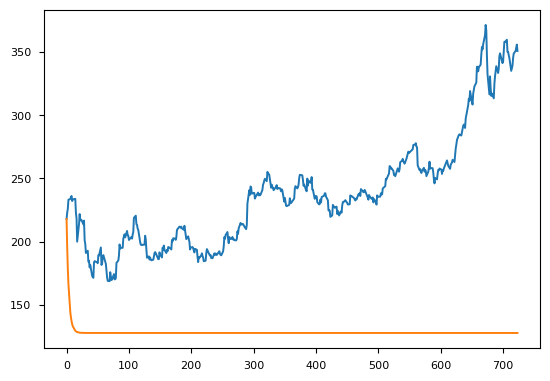

In [41]:
plt.plot(t_space,subset['Close'])
plt.plot(t_space,num_sol[:, 0].numpy())